### <b>Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>test/</b>
        male/
        female/
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ET8NMz2sl2ZEtlUVi5Hs-cIBS9VJhWixX8BM9uC1H1PnPg?download=1 -O CelebA_HQ_face_gender_dataset_test_1000.zip
!unzip CelebA_HQ_face_gender_dataset_test_1000.zip -d ./CelebA_HQ_face_gender_dataset_test_1000
%cd CelebA_HQ_face_gender_dataset_test_1000

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

data_dir = './CelebA_HQ_face_gender_dataset_test_1000/'

test_dataset = datasets.ImageFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 1000
Class names: ['female', 'male']


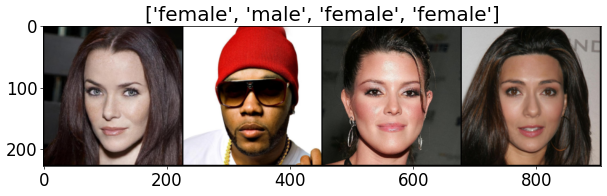

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(test_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Load Pre-trained Model</b>

In [5]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfAE05ATen9PopOPWzxLvMsBjzYIFOYaGaY2UpUcLETM7w?download=1 -O face_gender_classification_transfer_learning_with_ResNet18.pth

--2021-03-13 04:04:43--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfAE05ATen9PopOPWzxLvMsBjzYIFOYaGaY2UpUcLETM7w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZkFFMDVBVGVuOVBvcE9QV3p4THZNc0JqellJRk9ZYUdhWTJVcFVjTEVUTTd3P3J0aW1lPTZQUkVJdFhsMkVn [following]
--2021-03-13 04:04:43--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrc

In [6]:
save_path = 'face_gender_classification_transfer_learning_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [8]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    model
).to(device).eval()

### <b>Test Phase</b>

[Prediction Result Examples]


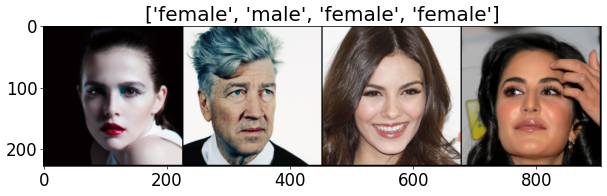

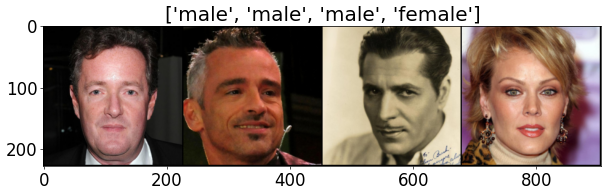

[Test] Loss: 0.0582 Acc: 98.2000% Time: 16.3725s


In [10]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>Prepare Adversarial Attack Libraries</b>

In [12]:
!pip install foolbox
!pip install advertorch

In [13]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 100 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Original Image Examples]


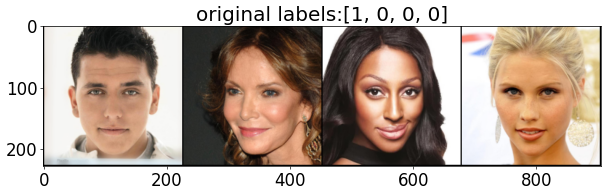

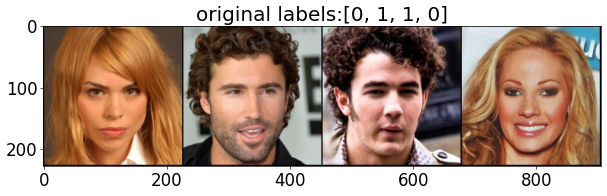

[Start Image Examples]


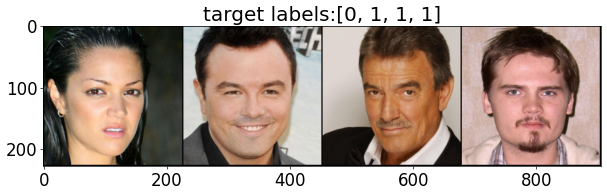

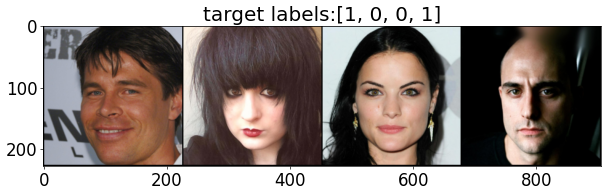

[Attack Result Examples]


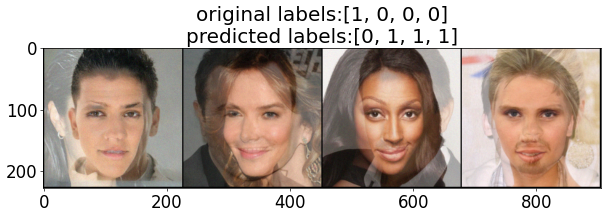

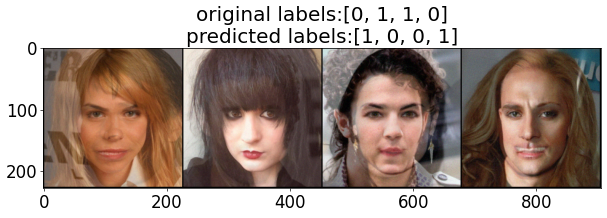

[Step #0] Loss: 0.0572 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 5.0763s (total 16 images)
[Step #10] Loss: 0.0632 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 31.8163s (total 176 images)
[Step #20] Loss: 0.0654 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 59.1542s (total 336 images)
[Step #30] Loss: 0.0635 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 86.0029s (total 496 images)
[Step #40] Loss: 0.0644 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 113.7437s (total 656 images)
[Step #50] Loss: 0.0644 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 140.7311s (total 816 images)
[Step #60] Loss: 0.0653 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 167.5038s (total 976 images)
[Validation] Loss: 0.0659 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 171.4914s (total 1000 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters

In [17]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=100,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 500 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Original Image Examples]


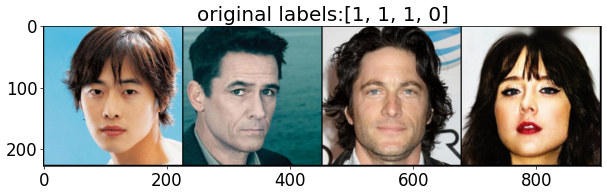

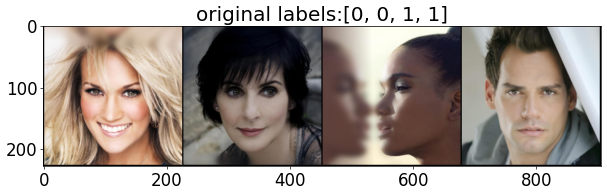

[Start Image Examples]


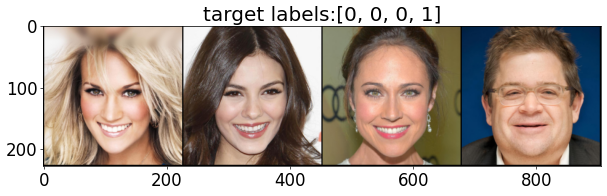

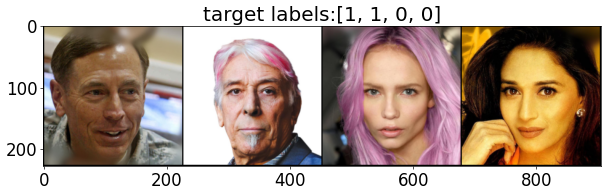

[Attack Result Examples]


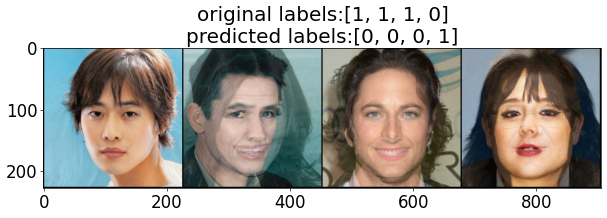

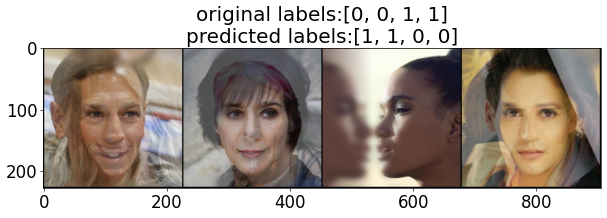

[Step #0] Loss: 0.0461 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 12.4848s (total 16 images)
[Step #10] Loss: 0.0461 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 114.8905s (total 176 images)
[Step #20] Loss: 0.0460 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 216.9429s (total 336 images)
[Step #30] Loss: 0.0460 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 319.8888s (total 496 images)
[Step #40] Loss: 0.0458 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 422.6280s (total 656 images)
[Step #50] Loss: 0.0462 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 525.3516s (total 816 images)
[Step #60] Loss: 0.0462 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 627.4348s (total 976 images)
[Validation] Loss: 0.0465 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 643.8655s (total 1000 images)
[Size of Perturbation]
Average L0 distance (the number of changed parame

In [18]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=500,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 1000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Original Image Examples]


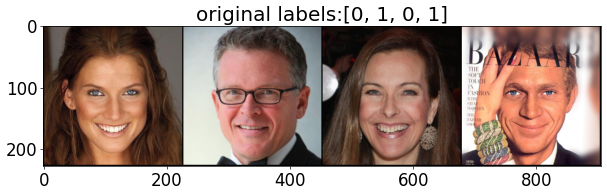

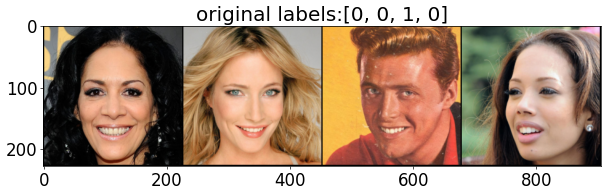

[Start Image Examples]


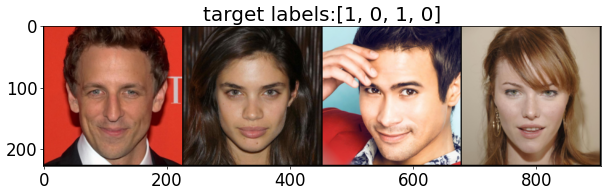

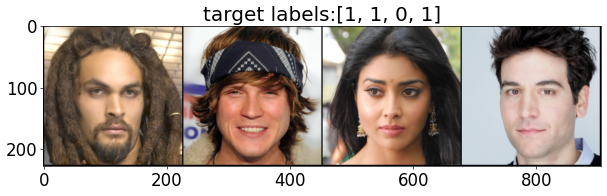

[Attack Result Examples]


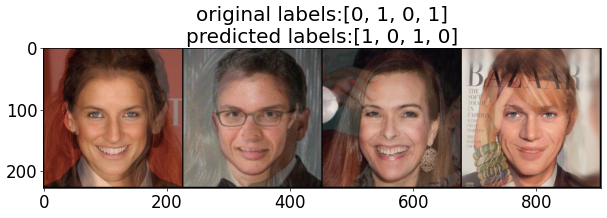

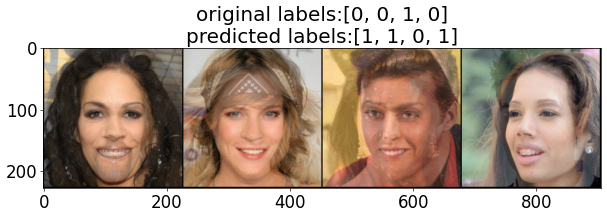

[Step #0] Loss: 0.0439 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 22.1224s (total 16 images)
[Step #10] Loss: 0.0472 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 220.0791s (total 176 images)
[Step #20] Loss: 0.0467 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 418.3526s (total 336 images)
[Step #30] Loss: 0.0465 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 617.7001s (total 496 images)
[Step #40] Loss: 0.0472 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 817.8896s (total 656 images)
[Step #50] Loss: 0.0465 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1017.8753s (total 816 images)
[Step #60] Loss: 0.0462 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1217.5467s (total 976 images)
[Validation] Loss: 0.0465 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1249.8466s (total 1000 images)
[Size of Perturbation]
Average L0 distance (the number of changed par

In [19]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=1000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 3000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Original Image Examples]


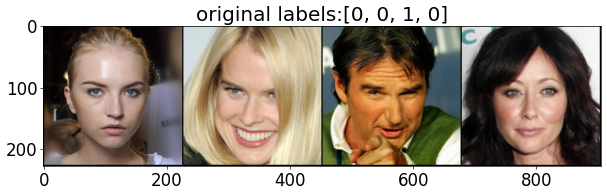

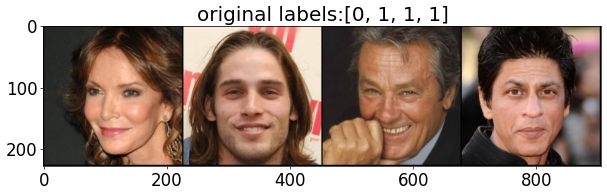

[Start Image Examples]


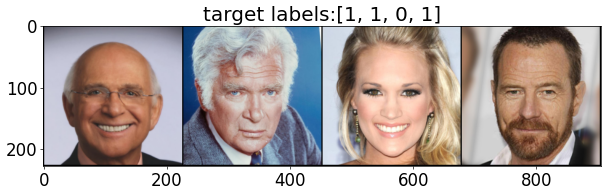

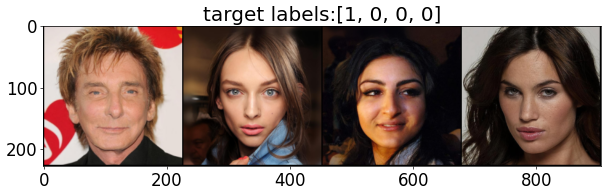

[Attack Result Examples]


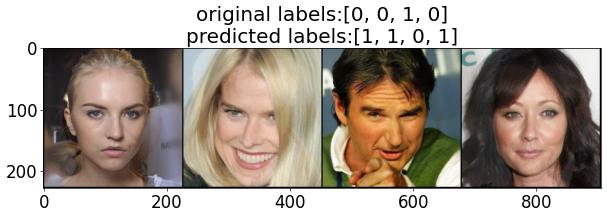

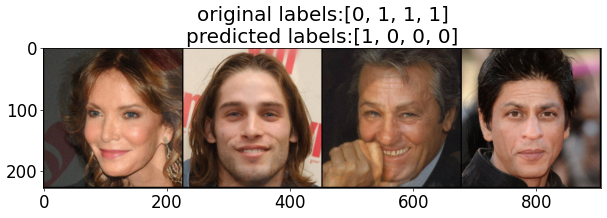

[Step #0] Loss: 0.0435 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 60.7395s (total 16 images)
[Step #10] Loss: 0.0482 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 644.3943s (total 176 images)
[Step #20] Loss: 0.0480 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1228.8432s (total 336 images)
[Step #30] Loss: 0.0470 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1813.0585s (total 496 images)
[Step #40] Loss: 0.0463 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2397.3067s (total 656 images)
[Step #50] Loss: 0.0461 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2981.7647s (total 816 images)
[Step #60] Loss: 0.0459 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3566.3199s (total 976 images)
[Validation] Loss: 0.0465 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3661.5473s (total 1000 images)
[Size of Perturbation]
Average L0 distance (the number of changed 

In [20]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=3000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 5000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Original Image Examples]


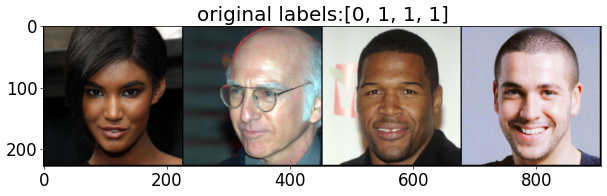

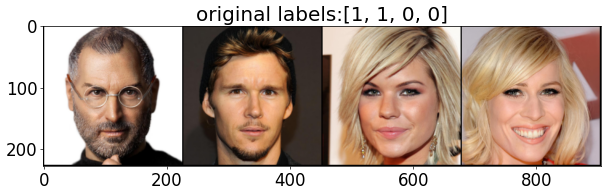

[Start Image Examples]


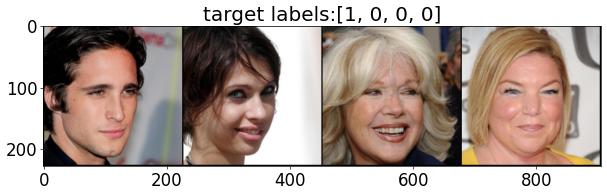

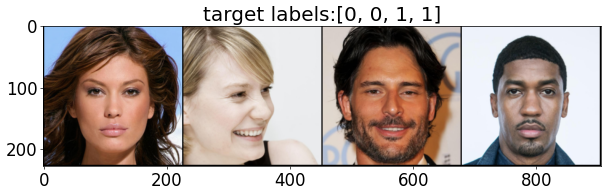

[Attack Result Examples]


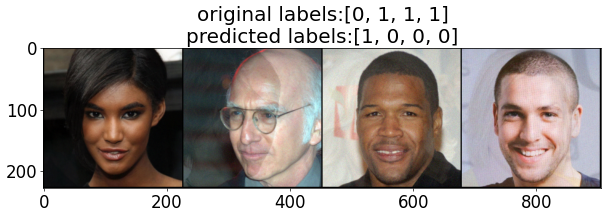

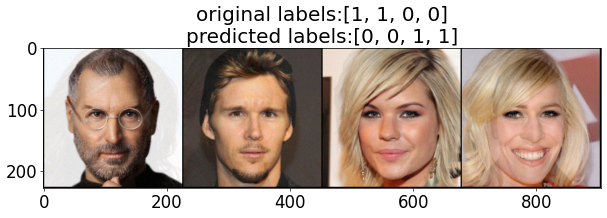

[Step #0] Loss: 0.0435 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 98.4866s (total 16 images)
[Step #10] Loss: 0.0484 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1058.6098s (total 176 images)
[Step #20] Loss: 0.0479 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2023.7138s (total 336 images)
[Step #30] Loss: 0.0474 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2984.1173s (total 496 images)
[Step #40] Loss: 0.0469 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3938.8308s (total 656 images)
[Step #50] Loss: 0.0464 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 4900.6566s (total 816 images)
[Step #60] Loss: 0.0460 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 5867.5230s (total 976 images)
[Validation] Loss: 0.0463 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 6025.1221s (total 1000 images)
[Size of Perturbation]
Average L0 distance (the number of changed

In [21]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=5000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 10000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Original Image Examples]


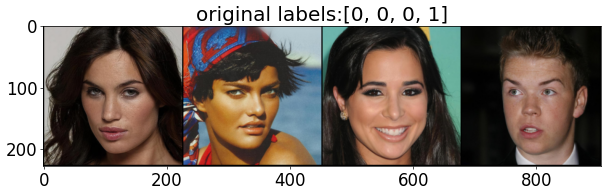

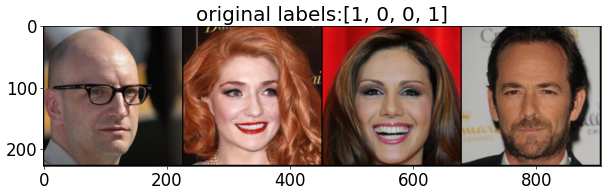

[Start Image Examples]


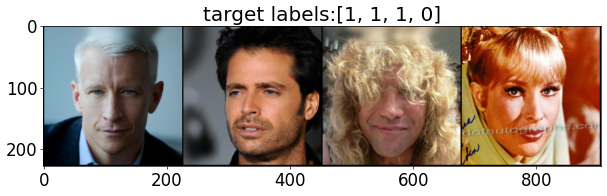

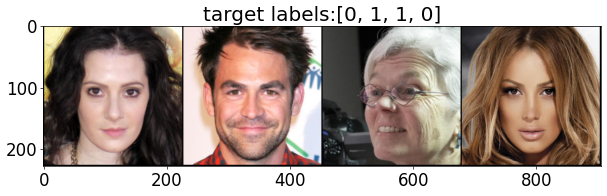

[Attack Result Examples]


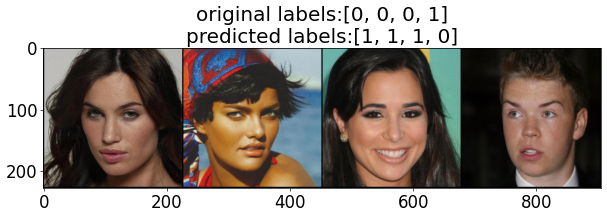

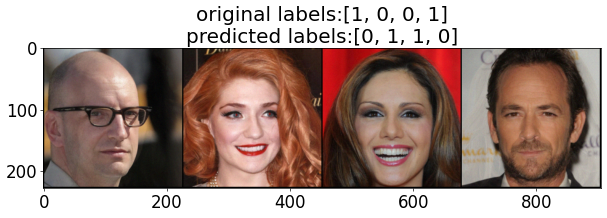

[Step #0] Loss: 0.0457 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 195.1165s (total 16 images)
[Step #10] Loss: 0.0449 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2121.4269s (total 176 images)
[Step #20] Loss: 0.0457 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 4050.4625s (total 336 images)
[Step #30] Loss: 0.0461 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 5975.9760s (total 496 images)
[Step #40] Loss: 0.0462 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 7901.6896s (total 656 images)
[Step #50] Loss: 0.0462 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 9826.7241s (total 816 images)


In [ ]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=10000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)